In [1]:
##google studio

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- 1. 資料載入與清理 ---
try:
    # 讀取 CSV 檔案
    df = pd.read_csv('k04.csv')

    # 清理欄位名稱：移除前後可能存在的空格
    df.columns = df.columns.str.strip()
    
    # 移除因 CSV 檔頭多一個逗號而產生的空欄位
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # 移除含有任何缺失值的資料行，確保模型能正常運行
    df.dropna(inplace=True)

    print("--- 資料檢查與清理完成 ---")
    print("清理後的欄位名稱:", df.columns.tolist())
    print("\n前5筆資料預覽:")
    print(df.head())
    print(f"\n清理後剩餘資料筆數: {len(df)}")

except FileNotFoundError:
    print("錯誤：找不到 k04.csv 檔案，請確認檔案路徑是否正確。")
    exit()


# --- 2. 特徵工程 (Feature Engineering) ---
print("\n--- 正在進行特徵工程 ---")

# a) 將 'Time1' (出發時間) 轉換為從午夜開始的總秒數
try:
    time_parts = df['Time1'].str.split(':', expand=True).astype(int)
    df['Time1_in_seconds'] = time_parts[0] * 3600 + time_parts[1] * 60 + time_parts[2]
    print("成功：已將 'Time1' 轉換為數值特徵 'Time1_in_seconds'。")
except Exception as e:
    print(f"錯誤：轉換 'Time1' 失敗: {e}")
    # 如果轉換失敗，則不使用此特徵
    if 'Time1_in_seconds' in df.columns:
        df = df.drop('Time1_in_seconds', axis=1)

# b) 將 'Time2' (行駛時間) 轉換為總秒數
try:
    time_parts = df['Time2'].str.split(':', expand=True).astype(int)
    # 處理可能存在的 HH:MM:SS 或 MM:SS 格式
    if time_parts.shape[1] == 3: # HH:MM:SS
        df['Time2_in_seconds'] = time_parts[0] * 3600 + time_parts[1] * 60 + time_parts[2]
    else: # MM:SS
        df['Time2_in_seconds'] = time_parts[0] * 60 + time_parts[1]
    print("成功：已將 'Time2' 轉換為數值特徵 'Time2_in_seconds'。")
except Exception as e:
    print(f"錯誤：轉換 'Time2' 失敗: {e}")
    if 'Time2_in_seconds' in df.columns:
        df = df.drop('Time2_in_seconds', axis=1)


# --- 3. 準備特徵(X)和目標(y) ---
# 目標 y: 預測是上午(AM)還是下午(PM)
y = df['AM/PM']

# 特徵 X: 使用星期、處理過的出發時間、行駛時間和起點站
# 檢查轉換後的欄位是否存在
numerical_features = [col for col in ['Week', 'Time1_in_seconds', 'Time2_in_seconds'] if col in df.columns]
categorical_features = ['Stp1']

X = df[numerical_features + categorical_features]

print(f"\n使用的特徵 (X): {X.columns.tolist()}")
print(f"使用的目標 (y): AM/PM")


# --- 4. 建立預處理與模型管道 (Pipeline) ---
# ColumnTransformer會對指定欄位做特定處理
# 1. 對類別特徵 'Stp1' 進行 One-Hot 編碼
# 2. 'remainder='passthrough'' 表示其他欄位(數值特徵)保持原樣
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 建立一個包含預處理和模型的 Pipeline
# 步驟1: 執行 preprocessor 進行資料轉換
# 步驟2: 將轉換後的資料放入邏輯斯迴歸模型進行訓練
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


# --- 5. 分割資料、訓練模型與評估 ---
# 將資料分為訓練集和測試集 (70% 訓練, 30% 測試)
# stratify=y 確保訓練集和測試集中的 AM/PM 比例與原始資料相同
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\n訓練資料筆數: {len(X_train)}")
print(f"測試資料筆數: {len(X_test)}")

# 訓練模型
model_pipeline.fit(X_train, y_train)

# 進行預測
y_pred = model_pipeline.predict(X_test)

# 輸出評估報告
print("\n--- 模型評估報告 ---")
print(classification_report(y_test, y_pred))

--- 資料檢查與清理完成 ---
清理後的欄位名稱: ['Date', 'Week', 'Time1', 'AM/PM', 'Stp1', 'Stp2', 'Time2']

前5筆資料預覽:
       Date  Week     Time1 AM/PM           Stp1          Stp2  Time2
0  20230101     7  04:00:00    AM  捷運芝山站(2號出口)_1  臺北市立大學(天母校區)  16:07
1  20230101     7  05:00:00    AM    捷運芝山站(2號出口)  臺北市立大學(天母校區)  21:22
2  20230101     7  08:00:00    AM  捷運芝山站(2號出口)_1  臺北市立大學(天母校區)  09:39
3  20230101     7  12:00:00    PM  捷運芝山站(2號出口)_1  臺北市立大學(天母校區)  12:06
4  20230101     7  12:00:00    PM  捷運芝山站(2號出口)_1  臺北市立大學(天母校區)  10:59

清理後剩餘資料筆數: 5013

--- 正在進行特徵工程 ---
成功：已將 'Time1' 轉換為數值特徵 'Time1_in_seconds'。
成功：已將 'Time2' 轉換為數值特徵 'Time2_in_seconds'。

使用的特徵 (X): ['Week', 'Time1_in_seconds', 'Time2_in_seconds', 'Stp1']
使用的目標 (y): AM/PM

訓練資料筆數: 3509
測試資料筆數: 1504

--- 模型評估報告 ---
              precision    recall  f1-score   support

          AM       0.67      0.76      0.71       741
          PM       0.73      0.64      0.68       763

    accuracy                           0.70      1504
   macro avg    

--- 1. 關鍵統計參數分析 ---

[分析] 行駛時間 (Time2_in_minutes) 的描述性統計：
count    5013.000000
mean       14.515234
std         5.501482
min         0.783333
25%        11.266667
50%        13.366667
75%        16.150000
max        58.933333
Name: Time2_in_minutes, dtype: float64

中位數 (Median): 13.37 分鐘
第一四分位數 (Q1): 11.27 分鐘 (代表 25% 的行程時間低於此值)
第三四分位數 (Q3): 16.15 分鐘 (代表 75% 的行程時間低於此值)
四分位距 (IQR = Q3 - Q1): 4.88 分鐘 (衡量資料中間 50% 的離散程度)
平均值 (Mean): 14.52 分鐘
標準差 (Std Dev): 5.50 分鐘 (衡量資料的波動性)


--- 2. 常態分佈分析 (行駛時間) ---


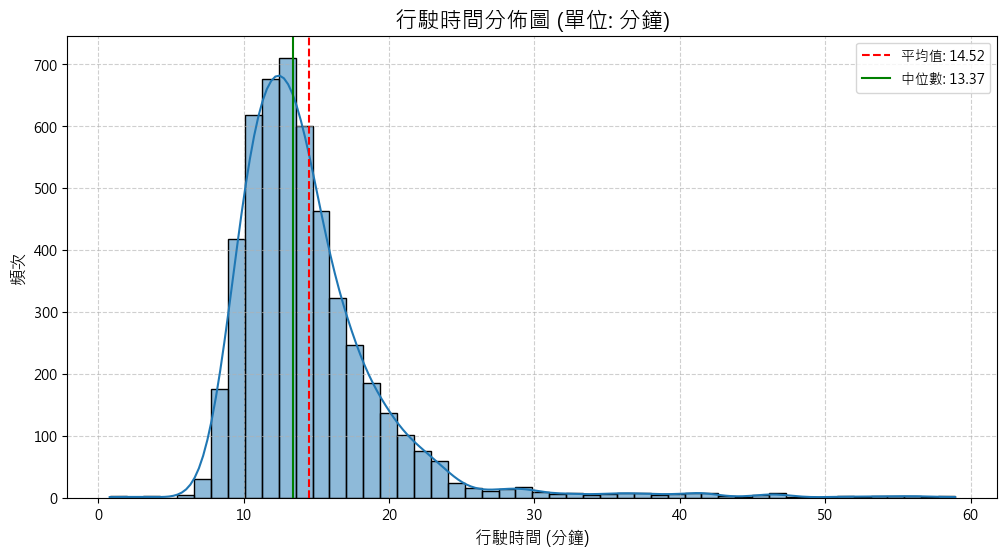

Shapiro-Wilk 常態檢定:
  - 檢定統計量: 0.7517
  - P-value: 0.0000
  - 結論: P-value < 0.05，拒絕虛無假設，資料非常態分佈。


--- 3. 盒鬚圖分析 ---


c:\Users\user\miniconda3\envs\flask\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5013.
  res = hypotest_fun_out(*samples, **kwds)


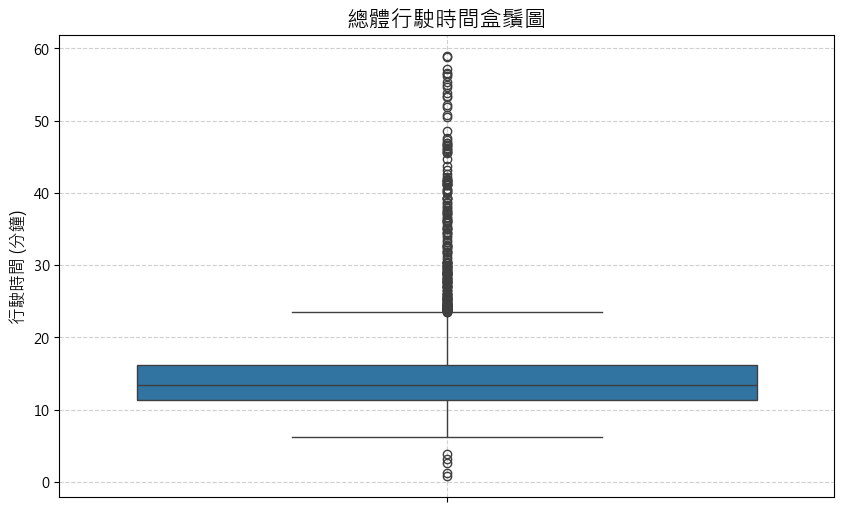

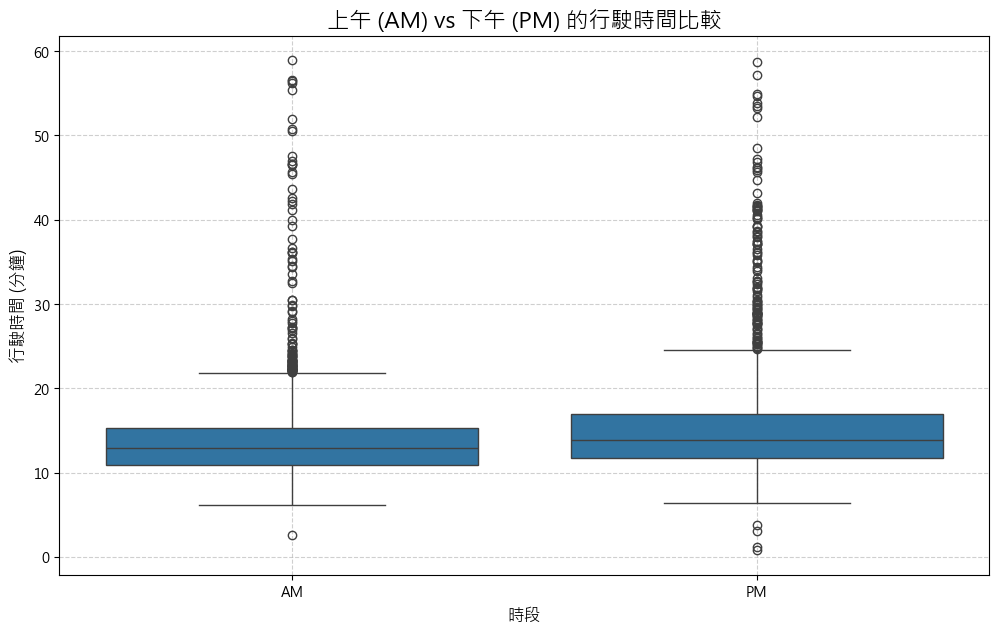

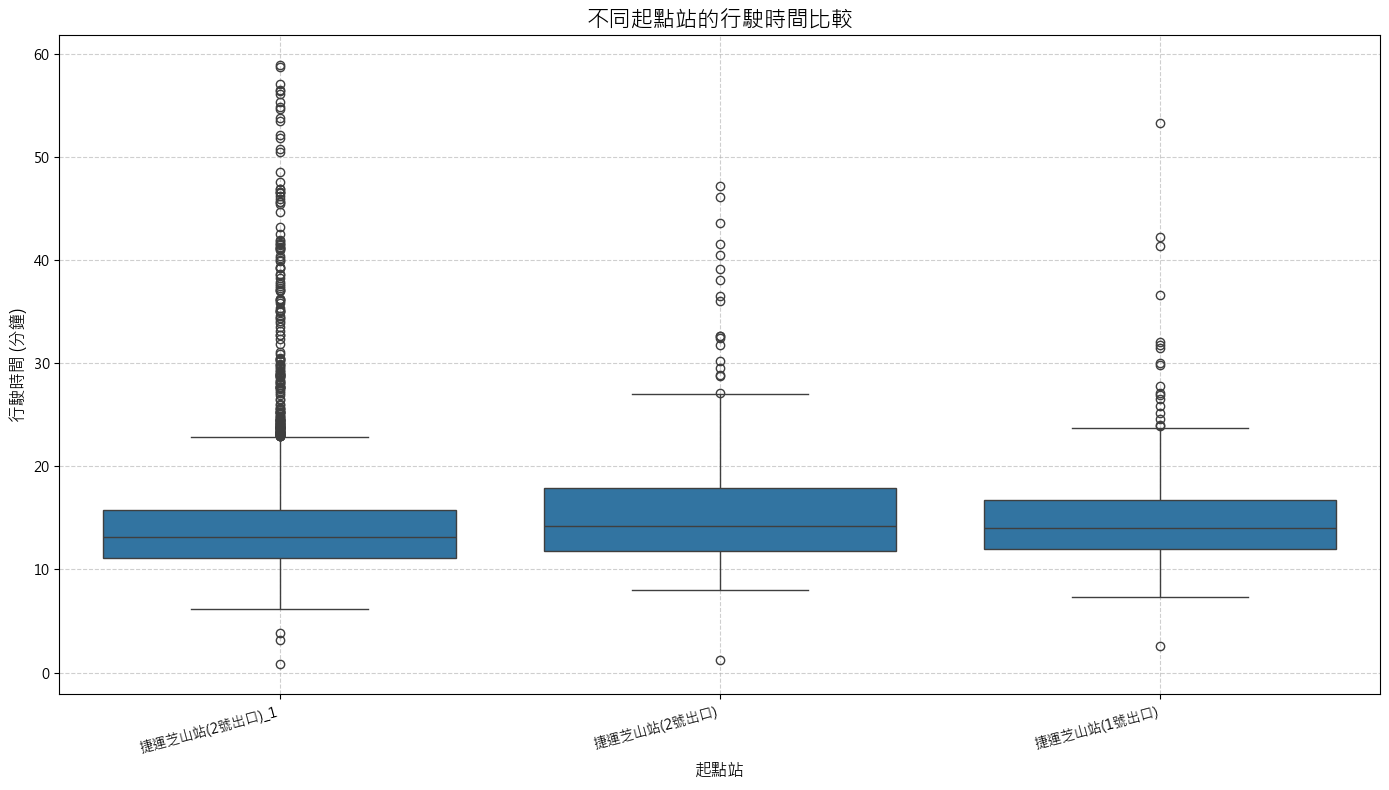

In [2]:
##google studio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- 1. 資料載入與清理 (與前次相同) ---
try:
    df = pd.read_csv('k04.csv')
    df.columns = df.columns.str.strip()
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.dropna(inplace=True)
except FileNotFoundError:
    print("錯誤：找不到 k04.csv 檔案，請確認檔案路徑是否正確。")
    exit()

# --- 2. 特徵工程 (與前次相同) ---
# 將 'Time1' (出發時間) 轉換為從午夜開始的總秒數
time_parts_t1 = df['Time1'].str.split(':', expand=True).astype(int)
df['Time1_in_seconds'] = time_parts_t1[0] * 3600 + time_parts_t1[1] * 60 + time_parts_t1[2]

# 將 'Time2' (行駛時間) 轉換為總秒數
time_parts_t2 = df['Time2'].str.split(':', expand=True).astype(int)
if time_parts_t2.shape[1] == 3:
    df['Time2_in_seconds'] = time_parts_t2[0] * 3600 + time_parts_t2[1] * 60 + time_parts_t2[2]
else:
    df['Time2_in_seconds'] = time_parts_t2[0] * 60 + time_parts_t2[1]

# 為了方便閱讀，將秒轉換為分鐘
df['Time2_in_minutes'] = df['Time2_in_seconds'] / 60

# 設定中文字體，以正確顯示圖表標題
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Heiti TC', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# --- 3. 關鍵統計參數分析 ---
print("--- 1. 關鍵統計參數分析 ---")
print("\n[分析] 行駛時間 (Time2_in_minutes) 的描述性統計：")
# 使用 .describe() 取得完整統計數據
desc_stats = df['Time2_in_minutes'].describe()
print(desc_stats)

# 計算四分位距 (IQR)
Q1 = desc_stats['25%']
Q3 = desc_stats['75%']
IQR = Q3 - Q1
median = desc_stats['50%']

print(f"\n中位數 (Median): {median:.2f} 分鐘")
print(f"第一四分位數 (Q1): {Q1:.2f} 分鐘 (代表 25% 的行程時間低於此值)")
print(f"第三四分位數 (Q3): {Q3:.2f} 分鐘 (代表 75% 的行程時間低於此值)")
print(f"四分位距 (IQR = Q3 - Q1): {IQR:.2f} 分鐘 (衡量資料中間 50% 的離散程度)")
print(f"平均值 (Mean): {desc_stats['mean']:.2f} 分鐘")
print(f"標準差 (Std Dev): {desc_stats['std']:.2f} 分鐘 (衡量資料的波動性)")

# --- 4. 常態分佈分析 (以行駛時間為例) ---
print("\n\n--- 2. 常態分佈分析 (行駛時間) ---")

# a) 視覺化：直方圖與核密度估計圖 (Histogram & KDE)
plt.figure(figsize=(12, 6))
sns.histplot(df['Time2_in_minutes'], kde=True, bins=50)
plt.title('行駛時間分佈圖 (單位: 分鐘)', fontsize=16)
plt.xlabel('行駛時間 (分鐘)', fontsize=12)
plt.ylabel('頻次', fontsize=12)
plt.axvline(df['Time2_in_minutes'].mean(), color='red', linestyle='--', label=f'平均值: {df["Time2_in_minutes"].mean():.2f}')
plt.axvline(df['Time2_in_minutes'].median(), color='green', linestyle='-', label=f'中位數: {df["Time2_in_minutes"].median():.2f}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# b) 統計檢定：Shapiro-Wilk 檢定
shapiro_test_stat, shapiro_p_value = stats.shapiro(df['Time2_in_minutes'])
print(f"Shapiro-Wilk 常態檢定:")
print(f"  - 檢定統計量: {shapiro_test_stat:.4f}")
print(f"  - P-value: {shapiro_p_value:.4f}")
if shapiro_p_value > 0.05:
    print("  - 結論: P-value > 0.05，無法拒絕虛無假設，資料可能為常態分佈。")
else:
    print("  - 結論: P-value < 0.05，拒絕虛無假設，資料非常態分佈。")

# --- 5. 盒鬚圖分析 ---
print("\n\n--- 3. 盒鬚圖分析 ---")

# a) 總體行駛時間盒鬚圖
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Time2_in_minutes'])
plt.title('總體行駛時間盒鬚圖', fontsize=16)
plt.ylabel('行駛時間 (分鐘)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# b) 依據 AM/PM 比較行駛時間
plt.figure(figsize=(12, 7))
sns.boxplot(x='AM/PM', y='Time2_in_minutes', data=df, order=['AM', 'PM'])
plt.title('上午 (AM) vs 下午 (PM) 的行駛時間比較', fontsize=16)
plt.xlabel('時段', fontsize=12)
plt.ylabel('行駛時間 (分鐘)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# c) 依據起點站 (Stp1) 比較行駛時間
plt.figure(figsize=(14, 8))
# 為了讓X軸標籤能完整顯示，進行旋轉
plt.xticks(rotation=15, ha='right') 
sns.boxplot(x='Stp1', y='Time2_in_minutes', data=df)
plt.title('不同起點站的行駛時間比較', fontsize=16)
plt.xlabel('起點站', fontsize=12)
plt.ylabel('行駛時間 (分鐘)', fontsize=12)
plt.tight_layout() # 自動調整圖表邊距
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()